# Practical Machine Learning for Physicists
## Week 6 Exercise 
## Deadline Monday 30th November at 12pm (Noon)

In this notebook you will be trying to predict a system using incomplete information. We will set up the equations of motions for a simple double pendulum (or should that be a double simple pendulum. Then we will see if a machine learning technique can predict the future position of the lower mass, using only the lower mass positions.

### Kinematics of the double pendulum
Let's specify our problem in terms of the following, with the origin at the pivot point of the top pendulum. This is just background for the machine learning tasks at the bottom of the notebook.

#### Positions
$$x_1 = L_1 \sin \theta_1$$
$$y_1 = -L_1 \cos \theta_1$$
$$x_2 = x_1 + L_2 \sin \theta_2$$
$$y_2 = y_1 - L_2 \cos \theta_2$$

#### Velocities
$$\dot{x}_1 = \dot{\theta_1} L_1 \cos \theta_1$$
$$\dot{y_1} =  \dot{\theta_1} L_1 \sin \theta_1$$
$$\dot{x_2} = \dot{x_1} + \dot{\theta_2} L_2 \cos \theta_2$$
$$\dot{y_2} = \dot{y_1} + \dot{\theta_2} L_2 \sin \theta_2$$


#### Accelerations

$$\ddot{x}_1 = -\dot{\theta_1}^2 L_1 \sin \theta_1 + \ddot{\theta_1} L_1 \cos \theta_1$$
$$\ddot{y_1} =  \dot{\theta_1}^2 L_1 \cos \theta_1 + \ddot{\theta_1} L_1 \sin \theta_1$$
$$\ddot{x_2} = \ddot{x_1} - \dot{\theta_2}^2 L_2 \sin \theta_2 + \ddot{\theta_2} L_2 \cos \theta_2$$
$$\ddot{y_2} = \ddot{y_1} + \dot{\theta_2}^2 L_2 \cos \theta_2 + \ddot{\theta_2} L_2 \sin \theta_2$$

#### Energies
Let $v_1^2 = \dot{x_1}^2 +\dot{y_1}^2$ and $v_2^2 = \dot{x_2}^2 +\dot{y_2}^2$ then the kinetic energies $T_1$ and $T_2$ are
$$ T_1 = \frac{1}{2}m_1 v_1^2 = \frac{1}{2}m_1 L_1^2 \dot{\theta_1}^2 $$
$$ T_2 = \frac{1}{2}m_2 v_2^2 = \frac{1}{2}m_2 \left( L_1^2 \dot{\theta_1}^2 + L_2^2 \dot{\theta_2}^2 + 2L_1 L_2 \cos(\theta_1-\theta_2) \dot{\theta_1} \dot{\theta_2} \right) $$

The potential enrgies are
$$V_1 = m_1 g y_1 = - m_1 g L_1 \cos \theta_1$$
$$V_2 = m_2 g y_2 = -m_2 g ( L_1 \cos \theta_1 + L_2 \cos \theta_2)$$

#### Langrangian
Now we form the Lagrangian $L=T-V=T_1+T_2 -V_1 -V_2$ and use the Euler-Lagrange equations:
$$\frac{\partial L}{\partial \theta_1} = \frac{d}{dt}\frac{\partial L}{\partial \dot{\theta_1}}$$
$$\frac{\partial L}{\partial \theta_2} = \frac{d}{dt}\frac{\partial L}{\partial \dot{\theta_2}}$$

Applying these gives
$$-(m_1+m_2) g L_1 \sin \theta_1 = (m_1+m_2) L_1^2 \ddot{\theta_1} + m_2 L_1 L_2 \sin(\theta_1-\theta_2) \dot{\theta_2}^2 +  m_2 L_1 L_2 \cos(\theta_1-\theta_2) \ddot{\theta_2} $$
and
$$ -m_2 g L_2 \sin \theta_2 = m_2 L_2 \ddot{\theta_2} + m_2 L_1 L_2 \cos(\theta_1-\theta_2) \ddot{\theta_1} + m_2 L_1 L_2 \sin(\theta_1-\theta_2) \dot{\theta_1}^2 $$ 


#### Equations of motions
$$ \omega_1 = \dot{\theta_1}$$  

$$ \omega_2 = \dot{\theta_2}$$ 
$$ \ddot\theta_1 = \frac{1}{L_1\xi}\left[L_1m_2\cos(\theta_1-\theta_2)\sin(\theta_1-\theta_2)\omega_1^2 + L_2m_2\sin(\theta_1-\theta_2)\omega_2^2 - m_2g\cos(\theta_1-\theta_2)\sin(\theta_2) + (m_1+m_2)g\sin(\theta_1) \right] $$
$$ \ddot\theta_2 = \frac{1}{L_2\xi}\left[L_2m_2\cos(\theta_1-\theta_2)\sin(\theta_1-\theta_2)\omega_2^2 + L_1(m_1+m_2)\sin(\theta_1-\theta_2)\omega_1^2+(m_1+m_2)g\sin(\theta_1)\cos(\theta_1-\theta_2) - (m_1+m_2)g\sin(\theta_2) \right] $$
where 
$$\xi \equiv \cos^2(\theta_1-\theta_2)m_2-m_1-m_2$$


In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.integrate import solve_ivp

import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense

#Set default figure size
#mpl.rcParams['figure.figsize'] = [12.0, 8.0] #Inches... of course it is inches
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch



In [2]:
def rhs(t, z, L1, L2, m1, m2, g):
    """
    Returns the right-hand side of the ordinary differential equation describing the double pendulem
    """
    theta1, w1, theta2, w2 = z    #The four components
    cos12 = np.cos(theta1 - theta2)
    sin12 = np.sin(theta1 - theta2)
    sin1 = np.sin(theta1)
    sin2 = np.sin(theta2)
    xi = cos12**2*m2 - m1 - m2
    w1dot = ( L1*m2*cos12*sin12*w1**2 + L2*m2*sin12*w2**2
            - m2*g*cos12*sin2      + (m1 + m2)*g*sin1)/(L1*xi)
    w2dot = -( L2*m2*cos12*sin12*w2**2 + L1*(m1 + m2)*sin12*w1**2
            + (m1 + m2)*g*sin1*cos12  - (m1 + m2)*g*sin2 )/(L2*xi)
    return w1, w1dot, w2, w2dot   #Return the w's and the wdot's


def to_cartesian(theta1, w1, theta2, w2, L1, L2):
    """ Transforms theta and omega to cartesian coordinates
    and velocities x1, y1, x2, y2, vx1, vy1, vx2, vy2
    """
    x1 = L1 * np.sin(theta1)
    y1 = -L1 * np.cos(theta1)
    x2 = x1 + L2 * np.sin(theta2)
    y2 = y1 - L2 * np.cos(theta2)
    vx1 = L1*np.cos(theta1)*w1
    vy1 = L1*np.sin(theta1)*w1
    vx2 = vx1 + L2*np.cos(theta2)*w2
    vy2 = vy1 + L2*np.sin(theta2)*w2
    return x1, y1, x2, y2, vx1, vy1, vx2, vy2
    

In [3]:
# Set up the initial conditions. Here we have lengths and masses
L1, L2 = 1., 1.
m1, m2 = 3., 1.
g = 9.81     # [m/s^2]. Gravitational acceleration

#Starting angles
z0=[np.pi/4,0,np.pi/4,0]
#z0=[0.1,0,0.1,0]

#Time ranges
tmax, dt = 50, 0.1
t = np.arange(0, tmax+dt, dt)

In [4]:
# Solve initial value problem
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y
print(np.shape(z))

# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)

(4, 501)


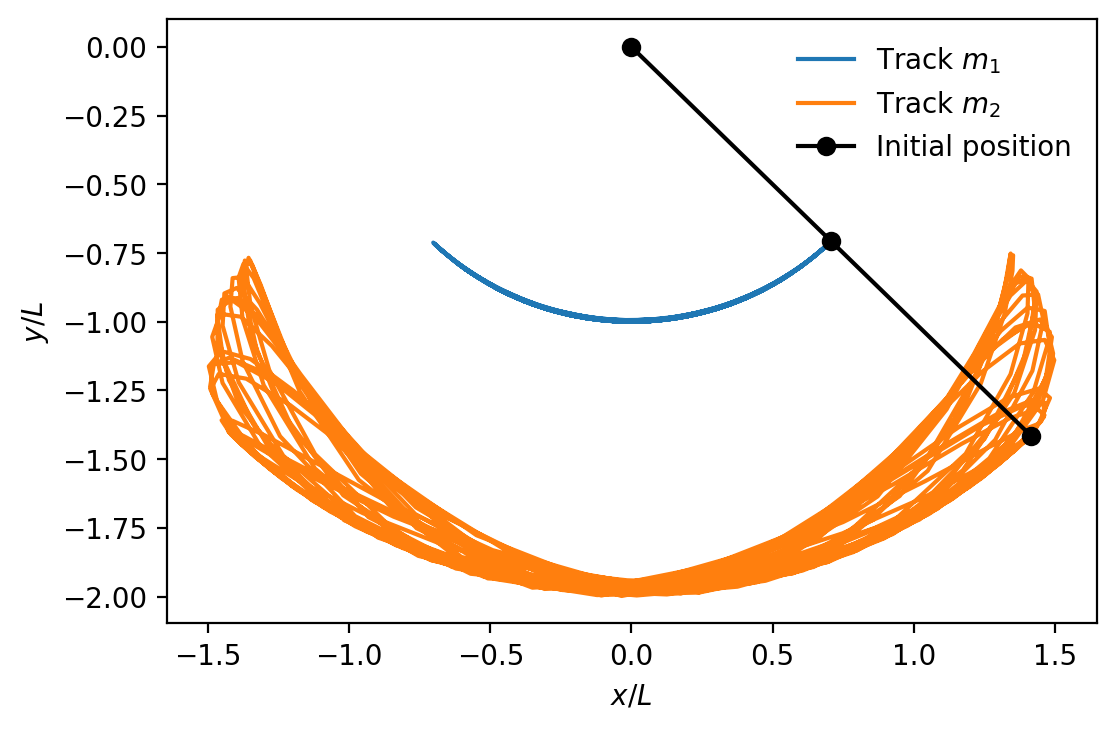

In [5]:
fig,ax=plt.subplots()
ax.plot(x1, y1, label=r"Track $m_1$")
ax.plot(x2, y2, label=r"Track $m_2$")
ax.plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
plt.ylabel(r"$y/L$")
plt.xlabel(r"$x/L$")
ax.legend()

# Exercises: Predicting Chaos
1. Design and train a recurrent neural network (of your choice) to predict the future positions, where future is defined as $t=t_0 + 20 \delta t$, of the masses $m_1$ and $m_2$ using their cartesian coordinates and the initial conditions  $z_0=[\pi/4,0,\pi/4,0]$. 
2. How stable is your network to variations in initial conditions? Make a plot of $x$ and $y$ vs time to show the network prediction in comparison to the solution from solve_ivp
3. How far into the future can a network predict? Make a plot showing how the deviation between predicted position and actual position (from solve_ivp above) vary as a function of extrapolation time from $t=t_0 + 20 \delta t$ to $t=t_0 + 100 \delta t$  (e.g. for each extrapolation time, train a new version of the network and then plot the performance)
4. Repeat steps 1-3 for the initial conditions $z_0=[\pi/2,0,\pi/2,0]$ which give a much more complex path.
5. Repeat steps 1-4 but only train your neural network on the cartesian coordinates of the mass $m_2$ (i.e without showing your neural network the positions of the mass $m_1$)

